# Figure 8

In [1]:
from __future__ import division
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

## Global parameters

In [2]:
N = 500 # number of firms
H = N*20 # number of workers
Lambda = .02 # separation rate
T = 200 # number of time steps
sampleSize = 500 # make smaller for faster computation
shockExtent = .1 # percentage of firms shocked
shockSize = .1 # size of the hiring policy reduction due to the shock

## Useful functions

In [3]:
# this function takes a firm and perform the job search of each of its unemployed
def hirings(i, firms, neighbors, unemps, nunemps, newHires, inNet, hs):
    # this conditional determines if the job search is ON the network or not
    if inNet:
        cands = firms[neighbors[i]]
    else:
        cands = firms[firms!=i]
    n1 = unemps[i]
    if n1 > 0:
        firms2 = np.array(np.random.choice(cands, n1))
        u1, u2 = np.unique(firms2, return_counts=True)
        n3 = len(firms2)
        allocs = firms2[np.random.rand(n3) < hs[firms2]]
        if len(allocs) > 0:
            u1, u2 = np.unique(allocs, return_counts=True)
            newHires[u1] += u2
            unemps[i] -= np.sum(u2)
    unemps[i] += nunemps[i]

    
# this function runs the model and return the time series of the unemployment rate of the economy
# it takes a network G, the number T of time steps to be run, and a boolean that indicates if the search is ON the network or not
def run(G, T, inNet, args=None):
    N = G.number_of_nodes()
    hs = np.array([G.node[firm]['h'] for firm in range(N)]) # a vector of hiring policies for fast computations
    firms = np.arange(N) # vector with ids of firms
    neighbors = np.array([np.array([True if neigh in G.neighbors(firm) else False for neigh in G.nodes()]) for  firm in G.nodes()]) # adjacency matrix of the network
    sizes = np.zeros(N) # vector with the size of each firm
    unemps = np.zeros(N) # vector with the number of unemployed associated to each firm
    nunemps = np.zeros(N) # vector with the number of new unemployed associated to each firms (those that were just separated)
    newHires = np.zeros(N) # vector with the number of new employees of each firm
    unempRates = [] # stores the time series of the unemployment rate
    degs = np.array([G.degree(firm) for firm in firms])

    for firm in G.nodes():
        G.node[firm]['us'] = []
    
    # initial condition of the model: all agents are unemployed and randomly assigned to firms
    u1, u2 = np.unique(np.random.randint(0, N, H), return_counts=True)
    unemps[u1] = u2
    
    # this is the main loop of the model
    for t in range(T):
        if args != None:
            periodShock, newH, shockExtent = args
            kbar = np.mean(degs)
            if t==periodShock:
                egoS = rd.choice(G.nodes())
                neighDistS = sorted(nx.single_source_shortest_path_length(G, egoS).items(), key=lambda (k, v):v)
                nShocked = 0
                while nShocked/N < shockExtent:
                    G.node[neighDistS[nShocked][0]]['h'] = newH
                    hs[neighDistS[nShocked][0]] = newH
                    nShocked += 1
                shockedFirms = [firm for firm in G.nodes() if not G.node[firm]['h'] == .5]
                neighborFirms = [firm for firm in G.nodes() if G.node[firm]['h'] == .5 and len(set(G.neighbors(firm)).intersection(shockedFirms))>0]
                nonshockedFirms = [firm for firm in G.nodes() if G.node[firm]['h'] == .5 and len(set(G.neighbors(firm)).intersection(shockedFirms))==0]
                
        nunemps = np.random.binomial(sizes.astype(int), Lambda)
        sizes -= nunemps
        [hirings(firm, firms, neighbors, unemps, nunemps, newHires, inNet, hs) for firm in firms]
        sizes += newHires
        for firm in G.nodes():
            G.node[firm]['us'].append(unemps[firm])
        newHires[:] = 0
        unempRates.append(np.sum(unemps)/H)
        
        if t==T-1:
            su = []
            nsu = []
            nu = []
            for firm in G.nodes():
                if firm in shockedFirms:
                    su.append(G.node[firm]['us'])
                elif firm in neighborFirms:
                    nu.append(G.node[firm]['us'])
                else:
                    nsu.append(G.node[firm]['us'])
            shockedU = np.sum(su, 0)
            nonshockedU = np.sum(nsu, 0)
            neighborsU = np.sum(nu, 0)
        
    return unempRates, shockedU, neighborsU, nonshockedU
    
def uSolNetwork(G):
    N = G.number_of_nodes()
    degs = np.array([G.degree(firm) for firm in range(N)])
    hs = np.array([G.node[node]['h'] for node in range(N)])
    hns = np.array([np.mean(hs[np.array(G.neighbors(i))]) for i in range(N)])
    semiSizes = np.sum(hs*hns*degs/Lambda)
    semiUnemps = np.sum(hs*degs)
    return semiUnemps/(semiUnemps+semiSizes)

def uSolGlobal(G):
    return Lambda/(Lambda + np.mean([G.node[i]['h'] for i in G.nodes()]))

## Run simulation

In [ ]:
UR = []
US = []
compS = {'su':[], 'nu':[], 'nsu':[]}
compR = {'su':[], 'nu':[], 'nsu':[]}

# simulation for scale-free network
GS = nx.barabasi_albert_graph(N, 2)
for firm in GS.nodes():
    GS.node[firm]['h'] = .5
uts = uSolNetwork(GS)
for sample in range(sampleSize):
    GS = nx.barabasi_albert_graph(N, 2)
    for firm in GS.nodes():
        GS.node[firm]['h'] = .5
    us, sus, nus, nsus = run(GS, 3*T, True, (T, .5*shockSize, shockExtent))
    US.append(us)
    compS['su'].append(sus)
    compS['nu'].append(nus)
    compS['nsu'].append(nsus)
uts = uSolNetwork(GS)

# simulation for regular graph
GS = nx.barabasi_albert_graph(N, 2)
for firm in GS.nodes():
    GS.node[firm]['h'] = .5
utr = uSolGlobal(GS)
for sample in range(sampleSize):
    GS = nx.barabasi_albert_graph(N, 2)
    for firm in GS.nodes():
        GS.node[firm]['h'] = .5
    ur, sur, nur, nsur = run(GS, 3*T, False, (T, .5*shockSize, shockExtent))
    UR.append(ur)
    compR['su'].append(sur)
    compR['nu'].append(nur)
    compR['nsu'].append(nsur)
utr = uSolGlobal(GS)


In [ ]:
uSeriesAll = {}

for shockSize in [.1, .25, .5]:
    uSeriesAll[shockSize] = []
    GS = nx.barabasi_albert_graph(N, 2)
    for sample in range(sampleSize):
        usSeries = []
        for firm in GS.nodes():
            GS.node[firm]['h'] = .5
        for se in np.linspace(0,1,11)[1:-1]:
            us, sus, nus, nsus = run(GS, 300, True, (T, .5*shockSize, se))
            ut = uSolNetwork(GS)
            usSeries.append((np.max(us[100::])-ut)/ut)
        uSeriesAll[shockSize].append(usSeries)


## Plot results

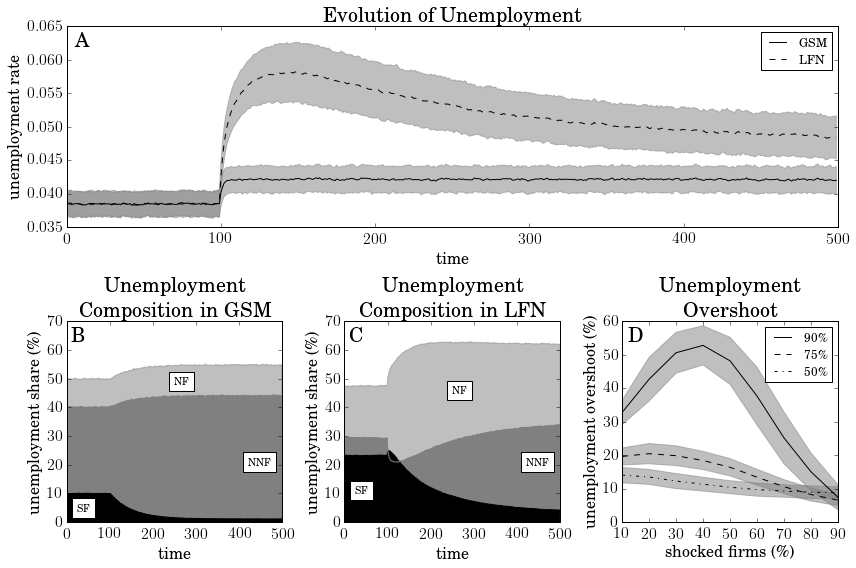

In [11]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig, big_axes = plt.subplots(figsize=(12, 8) , nrows=2, ncols=1, sharey=True) 

ax1 = plt.subplot2grid((2,3), (0,0), colspan=3)
x = range(len(UR[0][100:600]))
plt.fill_between(x, np.mean(UR, 0)[100:600]+np.std(UR, 0)[100:600], np.mean(UR, 0)[100:600]-np.std(UR, 0)[100:600], color='grey', alpha=.5)
plt.plot(np.mean(UR, 0)[100:600], '-k')
plt.fill_between(x, np.mean(US, 0)[100:600]+np.std(US, 0)[100:600], np.mean(US, 0)[100:600]-np.std(US, 0)[100:600], color='grey', alpha=.5)
plt.plot(np.mean(US, 0)[100:600], '--k')
plt.ylabel(r'unemployment rate', fontsize=16)
plt.xlabel(r'time', fontsize=16)
plt.legend([r'GSM', r'LFN'])
plt.text(5, .062, r'A', fontsize=20)
plt.title(r'Evolution of Unemployment', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)

ax2 = plt.subplot2grid((2,3), (1,0))
y = np.row_stack((np.mean(compR['su'],0)[100:600], np.mean(compR['nu'],0)[100:600], np.mean(compR['nsu'],0)[100:600]))
x = range(len(y[0]))
percent = y /  y.sum(axis=0) * 100 
plt.fill_between(x, percent[1], np.zeros(len(x)), color='grey', alpha=.5)
plt.fill_between(x, percent[2], np.zeros(len(x)), color='grey')
plt.fill_between(x, percent[0], np.zeros(len(x)), color='black')
plt.ylabel(r'unemployment share (\%)', fontsize=16)
plt.xlabel(r'time', fontsize=16)
plt.ylim(0, 70)
plt.text(10, 63, r'B', fontsize=20)
plt.text(25, 4, r'SF', bbox={'facecolor':'white', 'pad':5})
plt.text(420, 20, r'NNF', bbox={'facecolor':'white', 'pad':5})
plt.text(250, 48, r'NF', bbox={'facecolor':'white', 'pad':5})
plt.title(r'\begin{center} Unemployment\\Composition in GSM \end{center}', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)

ax3 = plt.subplot2grid((2,3), (1, 1))
y = np.row_stack((np.mean(compS['su'],0)[100:600], np.mean(compS['nu'],0)[100:600], np.mean(compS['nsu'],0)[100:600]))
x = range(len(y[0]))
percent = y /  y.sum(axis=0) * 100 
plt.fill_between(x, percent[1], np.zeros(len(x)), color='grey', alpha=.5)
plt.fill_between(x, percent[2], np.zeros(len(x)), color='grey')
plt.fill_between(x, percent[0], np.zeros(len(x)), color='black')
plt.plot(x, percent[2], color='grey')
plt.ylabel(r'unemployment share (\%)', fontsize=16)
plt.xlabel(r'time', fontsize=16)
plt.ylim(0, 70)
plt.text(10, 63, r'C', fontsize=20)
plt.text(25, 10, r'SF', bbox={'facecolor':'white', 'pad':5})
plt.text(420, 20, r'NNF', bbox={'facecolor':'white', 'pad':5})
plt.text(250, 45, r'NF', bbox={'facecolor':'white', 'pad':5})
plt.title(r'\begin{center} Unemployment\\Composition in LFN \end{center}', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)

ax3 = plt.subplot2grid((2,3), (1, 2))
x = range(10, 100, 10)
plt.fill_between(x, np.mean(uSeriesAll[.1],0)*100+np.std(uSeriesAll[.1],0)*100, np.mean(uSeriesAll[.1],0)*100-np.std(uSeriesAll[.1],0)*100, color='grey', alpha=.5)
plt.plot(x, np.mean(uSeriesAll[.1],0)*100, '-k')
plt.fill_between(x, np.mean(uSeriesAll[.25],0)*100+np.std(uSeriesAll[.25],0)*100, np.mean(uSeriesAll[.25],0)*100-np.std(uSeriesAll[.25],0)*100, color='grey', alpha=.5)
plt.plot(x, np.mean(uSeriesAll[.25],0)*100, '--k')
plt.fill_between(x, np.mean(uSeriesAll[.5],0)*100+np.std(uSeriesAll[.5],0)*100, np.mean(uSeriesAll[.5],0)*100-np.std(uSeriesAll[.5],0)*100, color='grey', alpha=.5)
plt.plot(x, np.mean(uSeriesAll[.5],0)*100, '-.k')
plt.legend([r'90\%', r'75\%', r'50\%'])
plt.text(12, 54, r'D', fontsize=20)
plt.ylabel(r'unemployment overshoot (\%)', fontsize=16)
plt.xlabel(r'shocked firms (\%)', fontsize=16)
plt.title(r'\begin{center} Unemployment\\Overshoot \end{center}', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)

plt.tight_layout()